In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
ABS_PATH = os.path.abspath("")
IMG_PATH = os.path.join(ABS_PATH, "images")

frames = [plt.imread(os.path.join(IMG_PATH, fname)) for fname in os.listdir(IMG_PATH) if fname.endswith(".jpg") or fname.endswith(".png")]

In [10]:
def local_operator(frame, kernel_size, function):
    
    k, n = kernel_size[0]//2, kernel_size[1]//2
    res_frame = np.zeros_like(frame)
    padded_frame = np.zeros(shape=(frame.shape[0]+2*k, frame.shape[1]+2*n, frame.shape[2]))
    padded_frame[k:-k, n:-n] = frame

    for c in range(padded_frame.shape[2]):
        for i in range(k, padded_frame.shape[0]-k):
            for j in range(n, padded_frame.shape[1]-n):
                curr_frame = padded_frame[i-k:i+k+1,j-n:j+n+1, c]
                res_frame[i-k,j-n, c] = function(curr_frame)
    return res_frame

In [11]:
def distance_transform(frame):
    frame_distances = []

    while frame.sum()>0:
        frame = local_operator(frame=frame, kernel_size=(3,3), function=lambda x: x.min())
        frame_distances.append(frame)

    return np.array(frame_distances).sum(axis=0)


In [12]:
def skeletonize(frame):

    def skeletonize_function(frame):
        frame = frame*kernel
        if frame.sum()==4:
            return 1
        else: 
            return 0
        
    def skeletonize_function_mean(frame):
        for x in kernels: frame = frame*x
        if frame.sum()>0:
            return frame.mean()
        else: 
            return 0
        
    base = np.array([1]*6 + [-1]*3).reshape(3,3)
    base[1,0], base[1,2] = 0, 0
    base2 = np.array([-1]*4+ [1]*5).reshape(3,3)
    base2[0,2], base2[2,0] = 0, 0 

    kernels = [base, base.T, np.flip(base), np.flip(base.T), base2, np.flip(base2,1).T, np.flip(base2,1), np.flip(base2,1).T, np.flip(base2)]
    
    frame = np.where(frame>0, 1, 0)
    for _ in range(1):
        for kernel in kernels:
            frame -= local_operator(frame, kernel_size=(3,3), function=skeletonize_function)
            # frame_new = local_operator(frame, kernel_size=(3,3), function=skeletonize_function)
    return frame

In [13]:
def binary(frame):
    frame *= 255/frame.max()
    return np.where(frame>150, True, False)

frame =  frames[0]
frame = frame.reshape(*frame.shape[:2], 1)


imgs = [frame]
for func in [binary, distance_transform, skeletonize]:
    frame = func(frame)
    imgs.append(frame)


fig, axes = plt.subplots(1, 4, figsize=(15,5))
titles = [r"$g$", r"binary$(g)$", r"distance_transform$($binary$(g))$", r"skeletonize$($distance_transform$($binary$(g)))$"]

for ax, t, x in zip(axes, titles, imgs):
    ax.imshow(x, cmap="gray")
    ax.set_title(t)
    ax.axis("off");

KeyboardInterrupt: 

In [14]:
def get_sobel(frame):
    kernel_sobel = np.array([-1,0,1] * 3).reshape(3,3)
    kernel_sobel[1, :] *= 2
    kernel_sobel = 1/4 * np.flip(kernel_sobel.T)
    frame = local_operator(frame=frame, kernel_size=(3,3), function=lambda x: np.abs((kernel_sobel*x).sum()))
    return frame

In [15]:
frame_edges = binary(get_sobel(imgs[0]))

In [104]:
def hough_transformation(frame):
    
    def hesse_normal_form(x, y, t):
        r = np.abs(x * np.cos(t) + y * np.sin(t)) 
        return r 
    
    def get_edge_points(frame):
        coors = []
        for i in range(frame.shape[0]):
            for j in range(frame.shape[1]):
                if frame[i,j]==1:
                    coors.append([i,j])
        return coors

    def hough_line(p):
        x_min = min(-100, p[0]-100) 
        x_max = min(100, p[1]) 

        x = np.arange(x_min, x_max)
        accumulator = []
        for t in thetas:
            curr_frame = np.zeros_like(frame)
            y = np.array(x*np.sin(t), dtype=int)
            try:
                curr_frame[x+p[0], y+p[1]] = 1
                curr_frame[y+p[0], x+p[1]] = 1
            except: pass

            hits = (frame * curr_frame).sum()
            accumulator.append(hits)
        return accumulator

    edge_points = get_edge_points(frame)
    thetas = np.linspace(-np.pi/2, np.pi/2, 180)
    
    hough_space = np.zeros(shape=(frame.shape[0]+200, len(thetas)))
    
    for p in edge_points:
        for i, t in enumerate(thetas):
            r = hesse_normal_form(x=p[0], y=p[1], t=t)
            hough_space[int(r),i] += 1


        accumulator = hough_line(p)
    
        x = np.arange(-100, 100)
        t = thetas[np.argmax(accumulator)]
        
        y = np.array(x*np.sin(t), dtype=int)
        try:
            frame[x+p[0], y+p[1]] += 1
            frame[y+p[0], x+p[1]] += 1
        except: pass

    return frame, hough_space



$\displaystyle r=x\cos(\theta) + y \sin(\theta)$

In [105]:
f, hough_space = hough_transformation(frame_edges.copy())

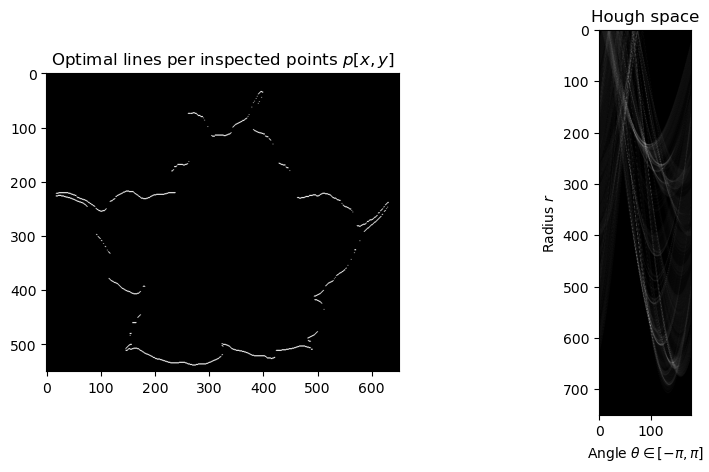

In [107]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(f, cmap="gray")
axes[0].set_title("Optimal lines per inspected points $p[x,y]$")

axes[1].imshow(hough_space, cmap="gray")
axes[1].set_title("Hough space")
axes[1].set_xlabel(r"Angle $\theta \in [-\pi, \pi]$")
axes[1].set_ylabel(r"Radius $r$");

In [ ]:
def get_edge_points(frame):
    coors = []
    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            if frame[i,j]==1:
                coors.append([i,j])
    return coors

edge_points = get_edge_points(frame)


thetas = np.linspace(-np.pi/2, np.pi/2, 50)
x = np.arange(-100, 100)
hough_space = np.zeros(shape=(frame.shape[0], len(thetas)))

best_thetas = []
frame = frame_edges.copy()

def hough_transformation(i):
    def hesse_normal_form(x, y, theta):
        r = np.abs(x * np.cos(theta) + y * np.sin(theta)) 
        return r 
    
    if i%len(thetas)==0:
        global frame
        global accumulator
        frame = frame_edges.copy()

        if i!=0: 
            best_thetas.append(thetas[np.argmax(accumulator)])


        for t, p in zip(best_thetas, edge_points):
            r = hesse_normal_form(x=p[0], y=p[1], theta=thetas)
            y = np.array(x*np.sin(t), dtype=int)
            try:
                frame[x+p[0], y+p[1]] = 1
                frame[y+p[0], x+p[1]] = 1
            except: pass
        if i!=0: 
            hough_space[r.astype(int), :] += accumulator
            
        accumulator = []
        


    for p in edge_points[i//len(thetas):i//len(thetas)+1]:
        
        curr_frame = np.zeros_like(frame)
        y = np.array(x*np.sin(thetas[i%len(thetas)]), dtype=int)
        try:
            curr_frame[x+p[0], y+p[1]] = 1
            curr_frame[y+p[0], x+p[1]] = 1
        except: pass
        hits = (frame_edges * curr_frame).sum()
        accumulator.append(hits)
        try:
            frame[x+p[0], y+p[1]] = 1
            frame[y+p[0], x+p[1]] = 1
        except: pass
        axes[0].clear()
        axes[1].clear()
        axes[0].set_title("Optimal lines per inspected points $p[x,y]$")
        axes[1].set_title("Hough space")
        axes[1].set_xlabel(r"Angle $\theta \in [-\pi, \pi]$")
        axes[1].set_ylabel(r"Radius $r$");
        axes[0].imshow(frame, cmap="gray")
        axes[1].imshow(hough_space, cmap="gray")

        return axes




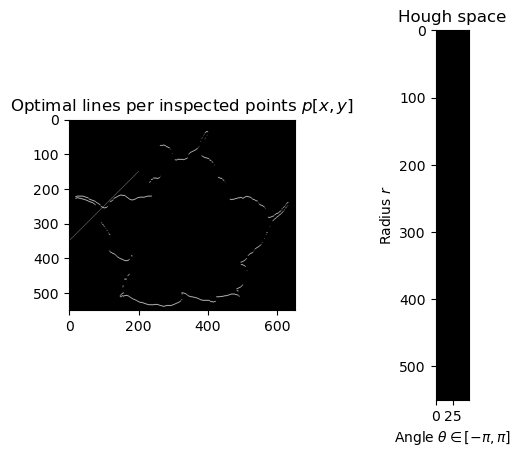

In [ ]:
from matplotlib import animation
fig, axes = plt.subplots(1,2)

ani = animation.FuncAnimation(fig, hough_transformation, frames=1000)


In [ ]:
ani.save(os.path.join(ABS_PATH, "test.gif"))

MovieWriter ffmpeg unavailable; using Pillow instead.
